In [15]:
import os
os.chdir("modulo/")

In [16]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [17]:
os.chdir("..")

In [20]:
dados = pd.read_csv("dados_ajustados.csv", decimal= ",", delimiter =";", index_col="Data")
retornos = dados.pct_change().dropna()
cov = np.array(retornos.cov())
e_r = np.array(retornos.mean()).reshape((retornos.shape[1], 1))

In [18]:
w = (np.random.randn(2)).reshape(2, 1)
w = w/sum(w)
w

array([[0.21814577],
       [0.78185423]])

In [23]:
import numpy as np

def minimize_vol(rp, e_r, cov, eps = 0.0001, alpha= 1):
    n =  e_r.shape[0]
    
    #Primeiro Chute
    w = (np.random.random(n)).reshape(n, 1)#Carteira
    w = w/sum(w)
    z = np.reciprocal(w)
    l = np.array([[0],[0]])#Multiplicadores de Lagrange
    
    #Calculando grad(c(x)) 
    dc = np.hstack((np.ones((n,1)), e_r))

    #Criando a Matriz A
    def generate_A(Sigma, dc, n):
        a = np.hstack([2*Sigma, dc])
        b = np.hstack([dc.T, np.zeros((2,2))])
        return np.vstack((a, b))
    
    #Criando o vetor b.
    def generate_b(Sigma, dc, e_r, l, w, rp):
        a = 2*Sigma@w + dc@l
        b = np.ones((1,n))@w - 1
        c = e_r.T@w - rp
        return -1*np.vstack((a, b, c))
    
    def grad(w, cov, l, dc):
        return (2*cov@w+ dc@l)
    
    A = generate_A(cov, dc, n)
    
    i = 0
    for i in range(10000):                                             
        b = generate_b(cov, dc, e_r, l, w, rp)
        #print("b: ",b, "\n")
        dx = np.linalg.inv(A)@b
        #print("dx: ", dx, "\n")
        dw, dl = dx[0:n][:], dx[n:n+2][:]
        w = w + alpha*dw
        #print("w: \n", w, "\n")
        l = l + alpha*dl
        
    return w

In [26]:
returns = np.linspace(min(e_r), max(e_r), 10)
carteiras_pi = np.array([minimize_vol(r, e_r, cov) for r in returns])
carteiras_scipy = np.array([minimize_vol2(r, e_r, cov).reshape((4, 1)) for r in returns])

vol1 = [float(np.sqrt(w.T@cov@w)) for w in carteiras_pi]
dic1 = {"Vol": vol1, "r": returns.reshape(returns.shape[0])}
df1 = pd.DataFrame(dic1)
ax = df1.plot(x="Vol", y="r", marker = "x", color="goldenrod", figsize=(12,6))

vol2 = [float(np.sqrt(w.T@cov@w)) for w in carteiras_scipy]
dic2 = {"Vol": vol2, "r": returns.reshape(returns.shape[0])}
df2 = pd.DataFrame(dic2)
df2.plot(x="Vol", y="r", marker = "x", color="red", ax = ax)

ValueError: cannot reshape array of size 2 into shape (4,1)

In [27]:
carteiras_pi

array([[[ 5.50388549e-02],
        [-3.06111692e-02],
        [-2.62167791e-01],
        [ 1.23774010e+00]],

       [[ 1.13792545e-01],
        [-2.10664162e-02],
        [ 8.32277480e-02],
        [ 8.24046123e-01]],

       [[ 1.72546236e-01],
        [-1.15216631e-02],
        [ 4.28623287e-01],
        [ 4.10352141e-01]],

       [[ 2.31299926e-01],
        [-1.97691004e-03],
        [ 7.74018825e-01],
        [-3.34184143e-03]],

       [[ 2.90053617e-01],
        [ 7.56784302e-03],
        [ 1.11941436e+00],
        [-4.17035824e-01]],

       [[ 3.48807307e-01],
        [ 1.71125961e-02],
        [ 1.46480990e+00],
        [-8.30729806e-01]],

       [[ 4.07560998e-01],
        [ 2.66573491e-02],
        [ 1.81020544e+00],
        [-1.24442379e+00]],

       [[ 4.66314688e-01],
        [ 3.62021022e-02],
        [ 2.15560098e+00],
        [-1.65811777e+00]],

       [[ 5.25068379e-01],
        [ 4.57468553e-02],
        [ 2.50099652e+00],
        [-2.07181175e+00]],

       [[ 

In [28]:
carteiras_scipy

array([[[0.00000000e+00],
        [2.62919027e-18],
        [5.65953534e-17],
        [1.00000000e+00]],

       [[1.66533454e-16],
        [8.50534829e-02],
        [4.15203745e-01],
        [4.99742772e-01]],

       [[5.78973758e-02],
        [1.77802764e-01],
        [3.58961316e-01],
        [4.05338544e-01]],

       [[1.52852244e-01],
        [2.13459644e-01],
        [3.05117513e-01],
        [3.28570599e-01]],

       [[2.47807112e-01],
        [2.49116524e-01],
        [2.51273710e-01],
        [2.51802654e-01]],

       [[3.42761980e-01],
        [2.84773404e-01],
        [1.97429907e-01],
        [1.75034709e-01]],

       [[4.37716848e-01],
        [3.20430284e-01],
        [1.43586104e-01],
        [9.82667639e-02]],

       [[5.32671716e-01],
        [3.56087164e-01],
        [8.97423012e-02],
        [2.14988189e-02]],

       [[6.78230016e-01],
        [3.21769984e-01],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.00000000e+00],
        [2.90088342e

In [24]:
from scipy.optimize import minimize

def minimize_vol2(target_return, er, cov):
    """
    target_ret -> W
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),)*n
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - weights.T@er
    }
    
    results = minimize(lambda weights, cov: weights.T@cov@weights, init_guess,
                       args=(cov,), method="SLSQP",
                       options={"disp":False},
                       constraints=(return_is_target, weights_sum_to_1),
                       bounds=bounds
                      )
    return results.x
    

<AxesSubplot:xlabel='Vol'>

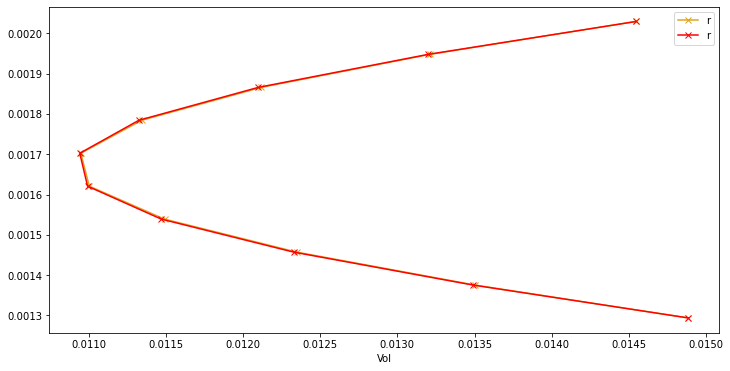

In [25]:
dados = pd.read_csv("dados_ajustados.csv", decimal= ",", delimiter =";")
dados = dados[["SPXI", "IBOV"]]
retornos = dados.pct_change().dropna()
cov = np.array(retornos.cov())
e_r = np.array(retornos.mean()).reshape(2, 1)


returns = np.linspace(min(e_r), max(e_r), 10)
carteiras_pi = np.array([np.round(minimize_vol(r, e_r, cov), 2) for r in returns])
carteiras_scipy = np.array([minimize_vol(r, e_r, cov).reshape((2, 1)) for r in returns])

vol1 = [float(np.sqrt(w.T@cov@w)) for w in carteiras_pi]
dic1 = {"Vol": vol1, "r": returns.reshape(returns.shape[0])}
df1 = pd.DataFrame(dic1)
ax = df1.plot(x="Vol", y="r", marker = "x", color="goldenrod", figsize=(12,6))

vol2 = [float(np.sqrt(w.T@cov@w)) for w in carteiras_scipy]
dic2 = {"Vol": vol2, "r": returns.reshape(returns.shape[0])}
df2 = pd.DataFrame(dic2)
df2.plot(x="Vol", y="r", marker = "x", color="red", ax = ax)

array([[0.00202945],
       [0.00129369]])

In [23]:
cov

array([[2.11616664e-04, 2.15415257e-05],
       [2.15415257e-05, 2.21610254e-04]])